In [1]:
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops

import helper_functions.fitMetrics as fitMetrics
import helper_functions.displayFunctions as display

# Matching Box and Segment

In [2]:
with open('predictions/saved_predictions.pkl', 'rb') as f:
    results = pickle.load(f)

df = pd.read_csv('data/experiment_boxes.csv')

## Visualizing Box and Segment

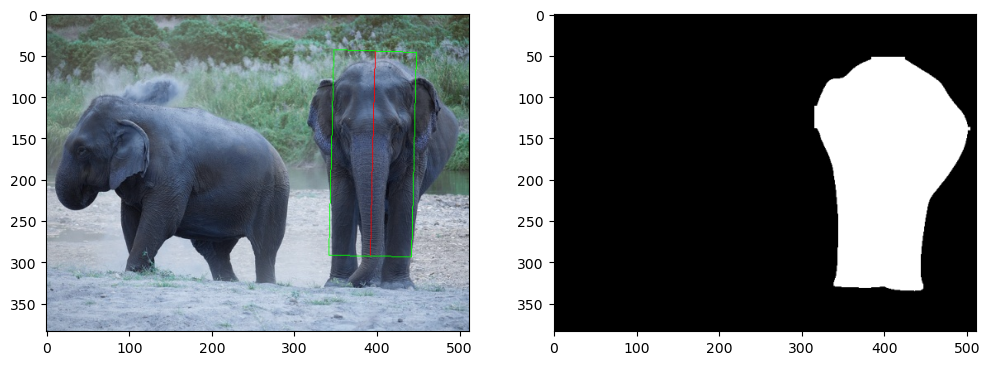

In [3]:
# image_name = 'MIRFLICKR25 - im12013.jpg' # 1 element
image_name = 'COCO - 000000372250.jpg'     # 2 elements
# image_name = 'CAT2000 -195.jpg'            # 0 elements
row_idx = 2

mask = results[image_name].masks[0].data.cpu().numpy()[0]
mask = cv2.resize(mask, (results[image_name].orig_shape[1], results[image_name].orig_shape[0]))

image = cv2.imread('images/images_nat/' + image_name)

df_image = df[df['file_name'] == image_name]
row = df_image.iloc[row_idx]

display.drawBB(image, row)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[1].imshow(mask, cmap='gray')
plt.show()


## Match bounding box with object detection segment

Calculating Intersection Over Union (IOU) and Dice Score.

**Intersection Over Union**
$$\frac{\text{Area of Intersection}}{\text{Area of Polygon} + \text{Area of Mask} - \text{Area of Intersection}}$$

**Dice Score**
$$\text{Dice} = \frac{2 \times \text{Area of Intersection}}{\text{Area of Polygon} + \text{Area of Mask}}$$


In [7]:
def get_od_match_row(row, predictions):
    matches = []
    for i in range(len(predictions[row['file_name']])):
        points = display.getBBPoints(row)
        mask = predictions[row['file_name']].masks[i].data.cpu().numpy()[0]
        mask = cv2.resize(mask, (predictions[row['file_name']].orig_shape[1], predictions[row['file_name']].orig_shape[0]))

        iou = fitMetrics.intersection_over_union(mask, points)
        dice_score = fitMetrics.dice_score(mask, points)

        detected_class = predictions[row['file_name']].names[int(predictions[row['file_name']].boxes.cls[i])]
        confidence_score = float(predictions[row['file_name']].boxes.conf[i])       
        
        matches.append((i, dice_score, iou, detected_class, confidence_score))

    if len(matches) == 0:
        matches.append((-1, 0.0, 0.0, 'None', 0.0))

    matches = sorted(matches, key=lambda x: x[2], reverse=True)

    return {
        'match_id': matches[0][0],
        'dice_score': matches[0][1],
        'iou': matches[0][2],
        'detected_class': matches[0][3],
        'confidence_score': matches[0][4]
    }

get_od_match_row(row, results)


{'match_id': 0,
 'dice_score': 0.7748471528108503,
 'iou': 0.62610836134565,
 'detected_class': 'elephant',
 'confidence_score': 0.9661673307418823}

## Match the whole dataset

In [8]:
def get_od_matches(df, predictions):
    box_id = []
    matches = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        if row['file_name'] not in predictions:
            continue

        box_id.append(row['Index'])
        matches.append(get_od_match_row(row, predictions))

    matches = pd.DataFrame(matches)
    matches.insert(0, 'box_id', box_id)

    return matches

od_matches = get_od_matches(df, results)
od_matches.to_csv('data_out/object_detection/box_matches.csv')
od_matches

100%|██████████| 39254/39254 [06:00<00:00, 108.78it/s]


,box_id,match_id,dice_score,iou,detected_class,confidence_score
0,0,0,0.145687,0.078124,person,0.898828
1,1,-1,0.000000,0.000000,None,0.000000
2,2,2,0.618767,0.442655,chair,0.604875
3,3,-1,0.000000,0.000000,None,0.000000
4,4,-1,0.000000,0.000000,None,0.000000
...,...,...,...,...,...,...
39249,39249,0,0.069947,0.035430,person,0.858416
39250,39250,0,0.866125,0.743869,bowl,0.420610
39251,39251,0,0.000000,0.000000,boat,0.433775
39252,39252,0,0.000000,0.000000,person,0.786977


# Homogeneity Analysis

We'll be calculating Homogeneity of the resulting pixels of the user indicated box after removing the detected segment from it. We will be using Gray-Level Co-occurrence Matrix (GLCM) Homogeneity. The GLCM is a statistical method that considers pixel pairs and calculates texture features. To measure homogeneity, the matrix emphasizes the presence of pixels with similar intensities.

* First, compute the GLCM of the image at various directions (e.g., 0°, 45°, 90°, and 135°).
* Then, calculate homogeneity as:
$$
\text{Homogeneity} = \sum_{i,j} \frac{P(i, j)}{1 + |i - j|}
$$
where $P(i,j)$ is the GLCM matrix value at position $(i,j)$.



In [4]:
def calculate_homogeneity(row, boxes, predictions):
    # Loading image and mask
    box_row = boxes.iloc[int(row['box_id'])]
    img = cv2.cvtColor(cv2.imread(display.getImgPath(box_row['file_name'])), cv2.COLOR_BGR2GRAY)
    mask = predictions[box_row['file_name']].masks[row['match_id']].data.cpu().numpy()[0]
    mask = cv2.resize(mask, (predictions[box_row['file_name']].orig_shape[1], predictions[box_row['file_name']].orig_shape[0]))

    # Cropping image and mask
    mask = display.crop_image(mask, box_row)
    img = display.crop_image(img, box_row)

    # Inverting mask
    mask = np.where(mask == 0, 1, 0)

    """
    Calculating homogeneity
    """

    # Apply the mask to the grayscale image and normalize
    masked_image = img * mask
    masked_image_uint8 = (masked_image * 255).astype(np.uint8)
    masked_pixels = masked_image_uint8[mask == 1]

    # Compute GLCM on masked pixels (reshape for GLCM input)
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(masked_pixels.reshape(-1, 1), distances, angles, levels=256, symmetric=True, normed=True)

    # Calculate homogeneity
    homogeneity = graycoprops(glcm, 'homogeneity')
    mean_homogeneity = homogeneity.mean()

    return mean_homogeneity

od_matches = pd.read_csv('data_out/object_detection/box_matches.csv', index_col=0)
row = od_matches.iloc[80]

homogeneity = calculate_homogeneity(row, df, results)

print(f'Homogeneity: {homogeneity}')

Homogeneity: 0.07241569600487592


## Calculate homogeneity for all dataset

In [6]:
def get_homogeneity_dataset(matches, boxes, predictions):
    box_ids = []
    homogeneities = []
    dice_scores = []
    ious = []

    exceptions = 0

    for _, row in tqdm(matches.iterrows(), total=len(matches)):

        if row['dice_score'] > 0.0:
            try:
                homogeneities.append(calculate_homogeneity(row, boxes, predictions))
            except:
                exceptions += 1
                continue
            box_ids.append(row['box_id'])
            dice_scores.append(row['dice_score'])
            ious.append(row['iou'])

    homogeneities = pd.DataFrame({
        'box_id': box_ids,
        'homogeneity': homogeneities,
        'dice_score': dice_scores,
        'iou': ious
    })

    print(f'Exceptions: {exceptions}')

    return homogeneities


homogeneities_df = get_homogeneity_dataset(od_matches, df, results)
homogeneities_df.to_csv('data_out/object_detection/homogeneities.csv')

100%|██████████| 39254/39254 [03:01<00:00, 216.32it/s]

Exceptions: 812
